In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
# Data analysis and visualization libraries
import pandas as pd
import matplotlib.pyplot as plt

# PySpark related imports for Spark session and data frame operations
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, avg
)

#### Initializing Spark Session

In [4]:
spark = SparkSession.builder \
                    .appName("Sentiment Analysis") \
                    .getOrCreate()

#### Database Connection Setup

In [5]:
# Database connection parameters
database_url = "jdbc:mysql://localhost:3306/tweets_data"
properties = {
    "user": "root",
    "password": "password",  
    "driver": "com.mysql.cj.jdbc.Driver"
}

# Reading data from the 'tweets' table into a DataFrame
df = spark.read.jdbc(url=database_url, table="tweets_sentiment", properties=properties)

In [6]:
df.show(5)

+---+----------+---------------+------------------+
|Ids|      Date|sentiment_score|sentiment_category|
+---+----------+---------------+------------------+
|  1|2009-04-07|            0.0|           neutral|
|  2|2009-04-07|            0.0|           neutral|
|  3|2009-04-07|            0.5|          positive|
|  4|2009-04-07|            0.2|          positive|
|  5|2009-04-07|         -0.625|          negative|
+---+----------+---------------+------------------+
only showing top 5 rows



### Analyzing Sentiment Distribution in the Dataset

This section is dedicated to exploring the distribution of sentiments (positive, neutral, negative) within the dataset. The analysis focuses on quantifying the frequency of each sentiment category, providing insights into the overall emotional tone conveyed in the tweets.

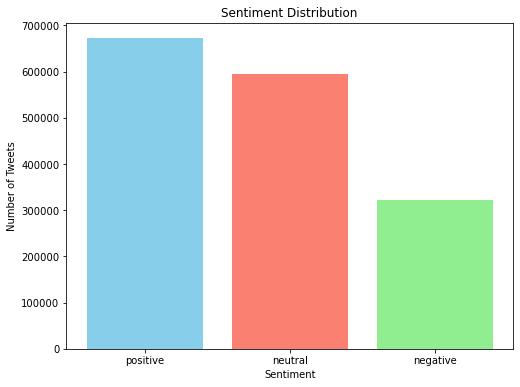

In [7]:
# Calculate the distribution of sentiments in the dataset
sentiment_counts = df.groupBy("sentiment_category").count().toPandas()

# Plotting the sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts["sentiment_category"], sentiment_counts["count"], color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.show()

### Observations and Conclusion

- **Predominance of Positive Sentiment:**
  - The data reveals that positive sentiments are the most common in the dataset, suggesting that the general tone of discourse during the observed period was predominantly upbeat and optimistic.

- **Prevalence of Neutral Sentiment:**
  - A substantial number of tweets fall into the neutral category, indicating a significant presence of tweets that are either purely informational or express indifference.

- **Presence of Negative Sentiment:**
  - Despite being less frequent than positive and neutral sentiments, a notable amount of tweets are categorized as negative, reflecting a spectrum of emotions and opinions in the dataset.

- **Consideration for Model Training:**
  - The skew towards positive sentiments in the dataset warrants caution, as it may lead to a bias in machine learning models trained on this data. It's crucial to be aware of this potential imbalance to ensure that models can accurately interpret and respond to a range of sentiments.


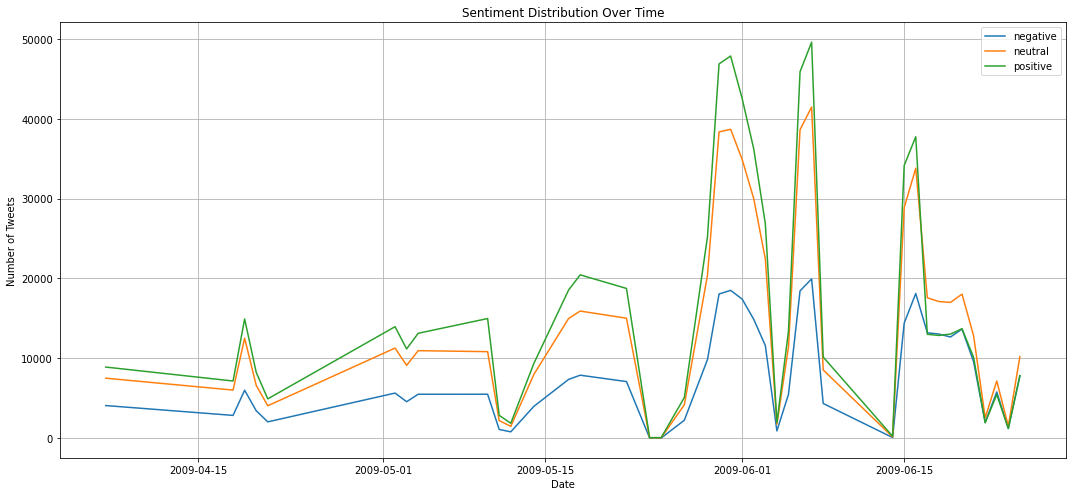

In [8]:
# Group the data by date and sentiment, and alias the "Date" column
grouped_df = df.groupBy(F.col('Date').cast("date").alias('Date'), 'sentiment_category').count().withColumnRenamed("count", "tweet_count")

# Pivot the data, using an alias for "Date" in the pivot
pivot_df = grouped_df.groupBy("Date").pivot("sentiment_category").sum("tweet_count").fillna(0)

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pivot_df_pd = pivot_df.toPandas()

# Plot the data
fig, ax = plt.subplots(figsize=(15, 7))
pivot_df_pd.plot(x="Date", kind='line', ax=ax)
ax.set_title('Sentiment Distribution Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.grid(True, which='both')
plt.tight_layout()
plt.show()

### Observations and Conclusion
Upon analyzing the distribution of sentiments over time, I can draw the following conclusions:

- The sentiments tend to follow the same general trend as the overall distribution of tweets over time, suggesting that the proportion of each sentiment category remains relatively constant.

- There are no noticeable peaks or declines in any particular sentiment category over time, implying that the relative proportion of positive, neutral, and negative tweets remains stable throughout the dataset's timeframe.

### Streamlining Data for Forecast Analysis

In preparation for forecasting, this segment focuses on refining the dataset by removing columns not pertinent to the analysis and performing data aggregation. The objective is to create a dataset that is more focused and suitable for predictive modeling.

- **Column Removal:**
  - The columns 'Ids' and 'sentiment_category' are removed, as they are not required for the upcoming forecast analysis.

- **Data Aggregation:**
  - The remaining data is aggregated by date, with the average sentiment score calculated for each day. This aggregation results in a concise dataset that captures the overall daily sentiment trends.

In [9]:
# Dropping unnecessary columns for forecasting
df = df.drop("Ids", "sentiment_category")

# Aggregating data by date and computing the average sentiment score
df_aggregated = df.groupBy("Date").agg(avg("sentiment_score").alias("average_sentiment"))

# Display the aggregated DataFrame
df_aggregated.show()

+----------+--------------------+
|      Date|   average_sentiment|
+----------+--------------------+
|2009-06-23|-0.02257459599294611|
|2009-04-18| 0.11291588472437784|
|2009-05-04| 0.10795067934985819|
|2009-06-20|-0.01495444303044...|
|2009-05-27| 0.10279296896004907|
|2009-04-19| 0.11334782861611123|
|2009-05-25|  0.1467607160714286|
|2009-06-18|-0.01878886513232...|
|2009-05-29| 0.11650297324823795|
|2009-06-04| 0.09436265812920008|
|2009-04-20| 0.11074908034723696|
|2009-06-03| 0.10293866766555491|
|2009-04-07| 0.09671465990349448|
|2009-04-21| 0.10964502053050912|
|2009-05-22| 0.11976949464965292|
|2009-06-22|-0.01605060417117...|
|2009-05-03| 0.11107732827310178|
|2009-06-17|-0.01638207166293692|
|2009-06-21|-0.00404604499615522|
|2009-06-06| 0.11167251463077218|
+----------+--------------------+
only showing top 20 rows



In [10]:
# Count the number of rows in the aggregated DataFrame
aggregated_count = df_aggregated.count()
print("Aggregated Dataset Size:", aggregated_count)

Aggregated Dataset Size: 41


### Exporting Aggregated Data for Further Analysis

To facilitate advanced forecasting using machine learning models in a different Python environment, the aggregated dataset will be exported as a CSV file. This step ensures that the prepared dataset is readily available and accessible for diverse modeling techniques in various analytical settings.

- **Export Procedure:**
  - The aggregated dataset, which encapsulates the average sentiment scores by date, is saved as a CSV file. This file format is chosen for its versatility and wide compatibility with various data processing tools and environments.

In [11]:
# Exporting the aggregated DataFrame to a CSV file
df_aggregated.write.csv("/home/rmoran/Desktop/CA2/ForecastDataset", header=True)

In [12]:
# Stop the Spark session
spark.stop()